In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from collections import Counter

- Efficient waste management is one of the biggest environmental challenges today. As populations grows, so does the volume of waste produced. Traditional sorting methods are often manual, time consuming and prone to error, making automation an attractive solution.

- This project will use Deep Learning and Convolutional Neural Networks to build a waste classification pipeline. We will be designing a two stage image classification system that mimics how real recycling systems sort materials.

- first stage: binary classifier that distinguishes between Organic and Recyclable waste.

- second stage, all images identified as Recyclable are passed to a multiclass material classifier, which categorizes them into specific recyclable material types: Paper, Plastic, Glass, Metal, or Cardboard.

# Datasets

2 datasets

1. Binary Waste Classification Dataset:
    Contains two broad categories of waste:
    - Organic
    - Recyclable 


2. Multiclass Recyclable Materials Dataset:
    Once an item is predicted as Recyclable, we need to identify the exact material type. For this, we use a second dataset containing individual folders for:
    - Paper, Plastic, Glass, Metal, Cardboard.


# **EDA**

In [ ]:
data_folders = {
    'binary': 'binary',
    'multiclass': 'multiclass'}

## Show image samples for each dataset

- This function performs the first stage of our EDA by visualizing sample images from each class in both datasets. It:

checks that the dataset folders exist

1.   identifies all class subfolders
2.   selects a limited number of sample images per class
3.   loads images using OpenCV
4.   converts them to RGB for correct visualization
5.   displays them in an arranged grid







---







- This step allows us to quickly verify that the folder structure is correctly organized, that images are readable and that classes visually make sense
- This inspection is a first step before moving on to more advanced EDA


Sample images from Binary Dataset:


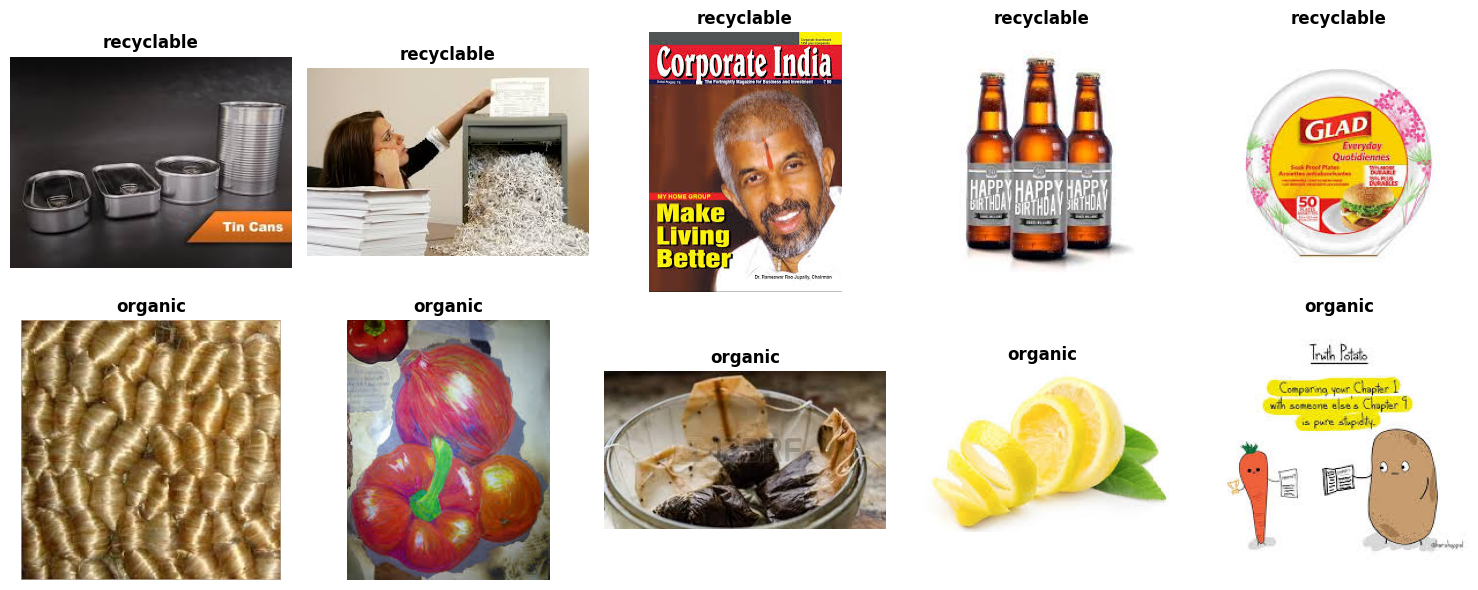


Sample images from Multiclass Dataset:


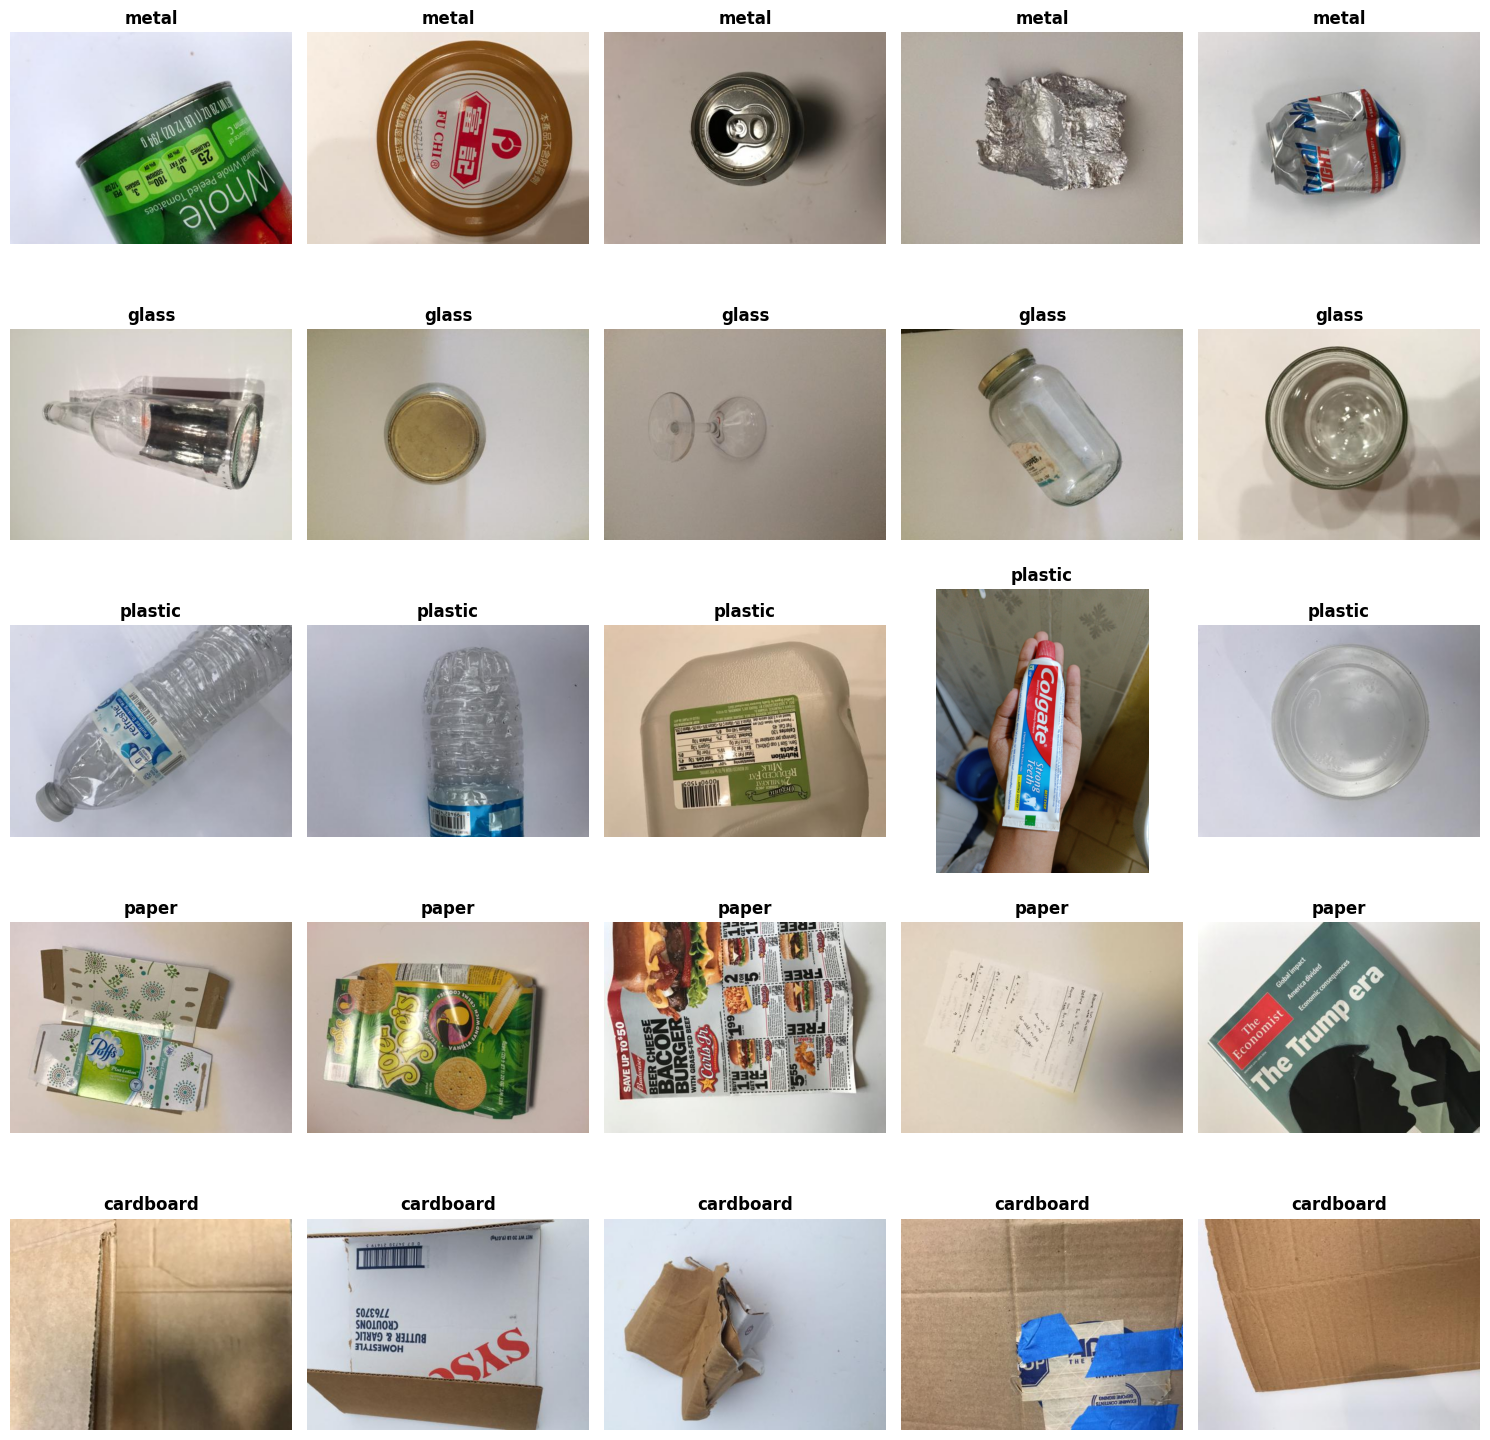

In [ ]:
def show_sample_images(folder_path, samples_per_class=5):
    if not os.path.exists(folder_path):
        print(f"Folder {folder_path} not found")
        return

    classes = [d for d in os.listdir(folder_path) if os.path.isdir(os. path.join(folder_path, d))] 

    fig, axes = plt.subplots(len(classes), samples_per_class, figsize=(15, 3*len(classes))) 

    if len(classes) == 1:
        axes = [axes]

    for i, class_name in enumerate(classes): 
        class_path = os.path.join(folder_path, class_name)
        image_files = [f for f in os.listdir(class_path) 
                      if f.lower(). endswith(('.jpg', '.jpeg', '.png'))][:samples_per_class]

        for j, img_file in enumerate(image_files): 
            img_path = os.path.join(class_path, img_file)

            try:
                img = cv2.imread(img_path) 
                img = cv2.cvtColor(img, cv2. COLOR_BGR2RGB) 

                # Display the image 
                if len(classes) == 1:
                    axes[j].imshow(img)
                    axes[j].set_title(f'{class_name}', fontweight='bold')
                    axes[j].axis('off')
                else:
                    axes[i, j].imshow(img)
                    axes[i, j].set_title(f'{class_name}', fontweight='bold')
                    axes[i, j].axis('off')
            except:
                print(f"Could not load {img_path}")

    plt.tight_layout()
    plt.show()

# Show samples from each dataset
for dataset_name, folder_path in data_folders.items():
    print(f"\nSample images from {dataset_name. title()} Dataset:")
    show_sample_images(folder_path)

## Get image properties


BINARY Dataset Image Properties:
Analysis of 100 images:
Width: min=173, max=372, mean=256
Height: min=135, max=291, mean=201
File size: min=1.7KB, max=25.9KB, mean=9.3KB
Aspect ratio: min=0.59, max=2.76, mean=1.34


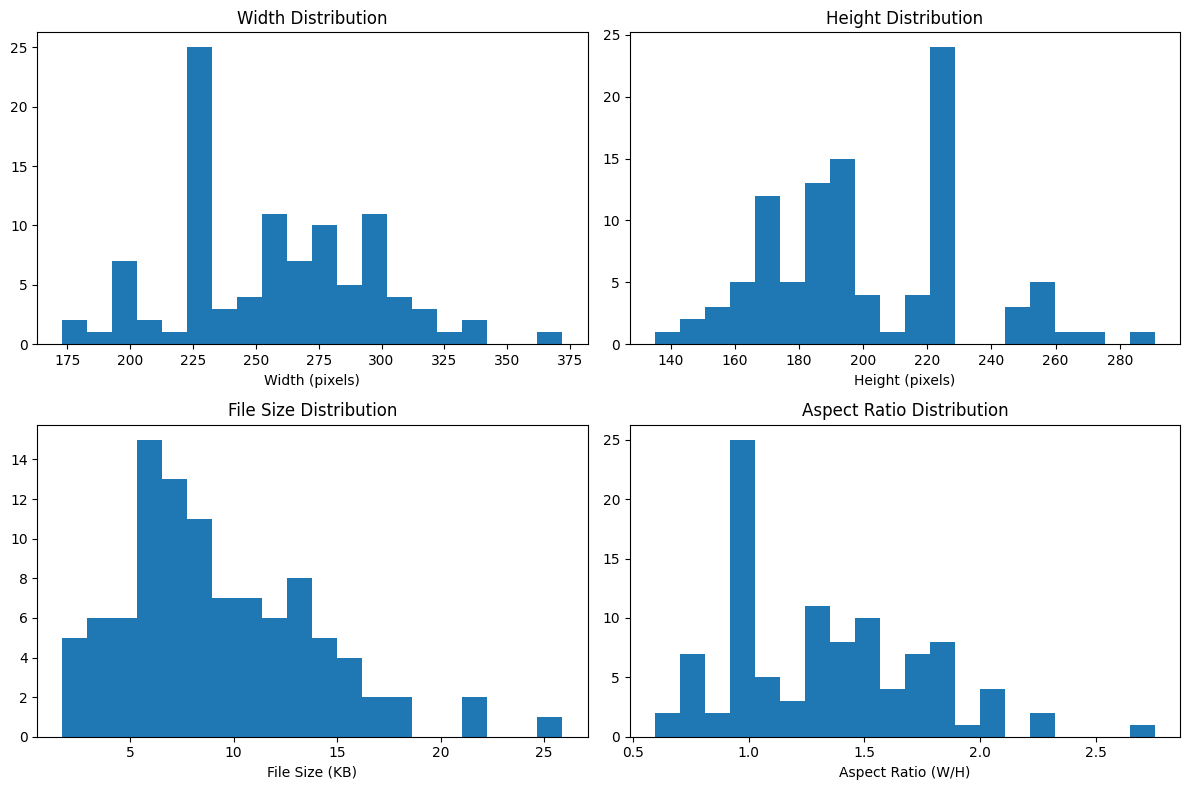


MULTICLASS Dataset Image Properties:
Analysis of 100 images:
Width: min=512, max=3000, mean=556
Height: min=384, max=4000, mean=449
File size: min=5.8KB, max=3795.4KB, mean=89.5KB
Aspect ratio: min=0.75, max=1.33, mean=1.32


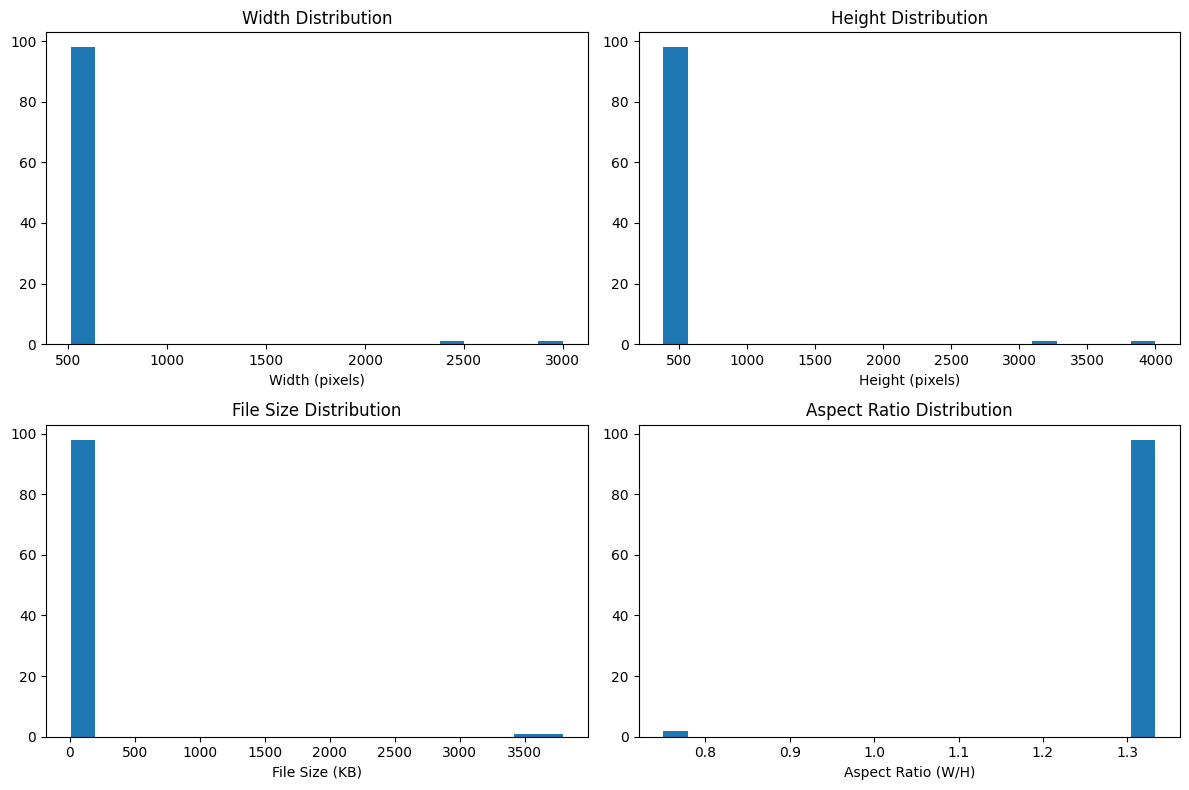

In [ ]:
def analyze_image_properties(folder_path, sample_size=100):
    if not os.path.exists(folder_path):
        print(f"Folder {folder_path} not found")
        return

    image_info = []

    # Collect all image paths from all class folders (we don't analyze everything, just build a list first)
    all_images = []
    for class_name in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_name)
        if os.path.isdir(class_path):
            for img_file in os.listdir(class_path):
                if img_file.lower().endswith(('.jpg', '.jpeg', '. png')):
                    all_images.append(os.path.join(class_path, img_file))

    # Take a random subset of images so the analysis stays fast
    sample_images = np.random.choice(all_images, min(sample_size, len(all_images)), replace=False)

    for img_path in sample_images: #Extract image properties for each sampled image
        try:
            img = cv2.imread(img_path)
            if img is not None:
                height, width, channels = img.shape
                file_size = os.path.getsize(img_path) / 1024

                image_info.append({
                    'width': width,
                    'height': height,
                    'channels': channels,
                    'file_size_kb': file_size,
                    'aspect_ratio': width/height
                })
        except:
            continue

    if not image_info:
        print("No valid images found")
        return

    df = pd.DataFrame(image_info) #put everything into a DataFrame so it's easier to inspect

    # stats
    print(f"Analysis of {len(df)} images:")
    print(f"Width: min={df['width'].min()}, max={df['width'].max()}, mean={df['width'].mean():.0f}")
    print(f"Height: min={df['height'].min()}, max={df['height'].max()}, mean={df['height']. mean():.0f}")
    print(f"File size: min={df['file_size_kb'].min():.1f}KB, max={df['file_size_kb'].max():.1f}KB, mean={df['file_size_kb'].mean():.1f}KB")
    print(f"Aspect ratio: min={df['aspect_ratio'].min():.2f}, max={df['aspect_ratio'].max():.2f}, mean={df['aspect_ratio']. mean():.2f}")

    #distributions
    fig, axes = plt. subplots(2, 2, figsize=(12, 8))

    axes[0, 0].hist(df['width'], bins=20)
    axes[0, 0].set_title('Width Distribution')
    axes[0, 0].set_xlabel('Width (pixels)')

    axes[0, 1]. hist(df['height'], bins=20)
    axes[0, 1].set_title('Height Distribution')
    axes[0, 1].set_xlabel('Height (pixels)')

    axes[1, 0].hist(df['file_size_kb'], bins=20)
    axes[1, 0].set_title('File Size Distribution')
    axes[1, 0].set_xlabel('File Size (KB)')

    axes[1, 1].hist(df['aspect_ratio'], bins=20)
    axes[1, 1].set_title('Aspect Ratio Distribution')
    axes[1, 1].set_xlabel('Aspect Ratio (W/H)')

    plt.tight_layout()
    plt.show()

    return df

# Run the image property analysis on each dataset
for dataset_name, folder_path in data_folders. items():
    print(f"\n{dataset_name.upper()} Dataset Image Properties:")
    analyze_image_properties(folder_path)

## Data Quality check

In [ ]:
def check_data_quality(folder_path):
    if not os. path.exists(folder_path):
        print(f"Folder {folder_path} not found")
        return

    corrupted_images = []
    valid_images = [] 
    duplicate_sizes = [] 

    for class_name in os.listdir(folder_path): 
        class_path = os.path.join(folder_path, class_name)
        if os.path.isdir(class_path):

            for img_file in os.listdir(class_path): 
                if img_file.lower().endswith(('.jpg', '.jpeg', '.png')): 
                    img_path = os.path.join(class_path, img_file)

                    try: 

                        img = cv2.imread(img_path)
                        if img is None:
                            corrupted_images.append(img_path)
                        else:
                            valid_images.append(img_path)
                            file_size = os.path.getsize(img_path)
                            duplicate_sizes.append(file_size)
                    except:
                        corrupted_images.append(img_path)

    size_counts = Counter(duplicate_sizes)
    potential_duplicates = [size for size, count in size_counts.items() if count > 1]

    print(f"\nData Quality Report:")
    print(f"Valid images: {len(valid_images)}")
    print(f"Corrupted images: {len(corrupted_images)}")
    print(f"Potential duplicates (same file size): {len(potential_duplicates)} groups")

    if corrupted_images:
        print("\nCorrupted images:")
        for img in corrupted_images[:10]:
            print(f"  - {img}")
        if len(corrupted_images) > 10:
            print(f"  ... and {len(corrupted_images) - 10} more")

# Quality for each dataset
for dataset_name, folder_path in data_folders. items():
    print(f"\n{dataset_name.upper()} Dataset Quality Check:")
    check_data_quality(folder_path)


BINARY Dataset Quality Check:

Data Quality Report:
✅ Valid images: 25077
❌ Corrupted images: 0
⚠️ Potential duplicates (same file size): 6957 groups

MULTICLASS Dataset Quality Check:

Data Quality Report:
✅ Valid images: 2460
❌ Corrupted images: 0
⚠️ Potential duplicates (same file size): 120 groups


## DATASET SUMMARY

In [ ]:
def dataset_summary(data_folders):
    total_images = 0 
    all_dataset_counts = {} 

    for dataset_name, folder_path in data_folders.items():
        print(f"\n{dataset_name.upper()} DATASET:")

        if not os.path.exists(folder_path):
            print(f"Folder {folder_path} not found")
            continue

        class_counts = {}

        for class_name in os.listdir(folder_path):
            class_path = os.path.join(folder_path, class_name)
            if os.path.isdir(class_path):

                image_files = [f for f in os.listdir(class_path)
                              if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
                class_counts[class_name] = len(image_files)

        dataset_total = sum(class_counts.values())
        all_dataset_counts[dataset_name] = class_counts
        total_images += dataset_total

        print(f"Total images: {dataset_total}")
        for class_name, count in class_counts.items():
            percentage = (count / dataset_total) * 100
            print(f"{class_name}: {count} images ({percentage:.1f}%)")

        print(f"Classes: {len(class_counts)}")

        # Imbalance check 
        if class_counts:
            min_count = min(class_counts.values())
            max_count = max(class_counts.values())
            imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')

            print(f"Balance ratio: {imbalance_ratio:.2f}")
            if imbalance_ratio > 3:
                print("Dataset is imbalanced")
            else:
                print("Dataset is reasonably balanced")
        else:
            print("No classes found in this dataset.")

    print(f"\nTOTAL IMAGES ACROSS ALL DATASETS: {total_images}")

dataset_summary(data_folders)


BINARY DATASET:
Total images: 25077
recyclable: 11111 images (44.3%)
organic: 13966 images (55.7%)
Classes: 2
Balance ratio: 1.26
Dataset is reasonably balanced

MULTICLASS DATASET:
Total images: 2460
metal: 410 images (16.7%)
glass: 501 images (20.4%)
plastic: 552 images (22.4%)
paper: 594 images (24.1%)
cardboard: 403 images (16.4%)
Classes: 5
Balance ratio: 1.47
Dataset is reasonably balanced

TOTAL IMAGES ACROSS ALL DATASETS: 27537


This function provides a complete summary of both datasets:
- The number of images per class helps determine whether each class has enough training samples.
- The percentage contribution of each class is useful for detecting overrepresented categories.
- The Balance Ratio (largest Class Size/Smallest Class Size) will give insights about data balance . If ratio > 3  it indicates a strong imbalance, which can lead the model to favor the majority class.
- The total number of images will helps estimate training time

# **Preprocessing**

## Reshaping the datasets

In [ ]:
def preprocess_image(img_path, target_size=(224, 224)):
    try:
        img = cv2.imread(img_path)
        if img is None:
            return None

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
        img = cv2.resize(img, target_size)
        img = img.astype('float32') / 255.0 

        return img 

    except:
        return None

In [ ]:
X_binary = []
y_binary = []
X_multiclass = []
y_multiclass = []

def load_and_preprocess_dataset(folder_path, target_list_X, target_list_y, class_mapping=None):
    for class_name in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_name)
        if os.path.isdir(class_path):
            print(f"  Processing class: {class_name}")
            for img_file in os.listdir(class_path):
                if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(class_path, img_file)
                    preprocessed_img = preprocess_image(img_path)
                    if preprocessed_img is not None:
                        target_list_X.append(preprocessed_img)
                        if class_mapping is not None:
                            target_list_y.append(class_mapping[class_name])
                        else:
                            target_list_y.append(0 if class_name == sorted(os.listdir(folder_path))[0] else 1)

In [ ]:
import tensorflow as tf

binary_dataset_path = data_folders['binary']

binary_classes = sorted(
    [d for d in os.listdir(binary_dataset_path)
     if os.path.isdir(os.path.join(binary_dataset_path, d))]
)
print("Binary Classes:", binary_classes)

binary_class_map = {binary_classes[0]: 0, binary_classes[1]: 1}
print(f"Binary Class Mapping: {binary_class_map}")

binary_ds = tf.keras.utils.image_dataset_from_directory(
    binary_dataset_path,
    labels="inferred",
    label_mode="int",
    class_names=binary_classes,
    image_size=(224, 224),    
    batch_size=32,            
    shuffle=True
)

binary_ds = binary_ds.prefetch(tf.data.AUTOTUNE)


Binary Classes: ['organic', 'recyclable']
Binary Class Mapping: {'organic': 0, 'recyclable': 1}
Found 25077 files belonging to 2 classes.
Binary dataset ready (streaming batches, not loading into RAM!)


In [ ]:
# multiclass set
multiclass_dataset_path = data_folders['multiclass']

multiclass_classes = sorted([d for d in os.listdir(multiclass_dataset_path) if os.path.isdir(os.path.join(multiclass_dataset_path, d))])

multiclass_class_map = {class_name: i for i, class_name in enumerate(multiclass_classes)}
print(f"Multiclass Class Mapping: {multiclass_class_map}")

load_and_preprocess_dataset(multiclass_dataset_path, X_multiclass, y_multiclass, class_mapping=multiclass_class_map)

X_multiclass = np.array(X_multiclass)
y_multiclass = np.array(y_multiclass)
print(f"Multiclass Dataset - X_multiclass shape: {X_multiclass.shape}, y_multiclass shape: {y_multiclass.shape}")

Multiclass Class Mapping: {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4}
  Processing class: metal
  Processing class: glass
  Processing class: plastic
  Processing class: paper
  Processing class: cardboard
Multiclass Dataset - X_multiclass shape: (2460, 224, 224, 3), y_multiclass shape: (2460,)


# **Binary Model**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [ ]:
binary_dataset_path = data_folders['binary']

binary_classes = sorted(
    [d for d in os.listdir(binary_dataset_path)
     if os.path.isdir(os.path.join(binary_dataset_path, d))]
)

batch_size = 32
img_size = (224, 224)

# Train 80%
train_ds = tf.keras.utils.image_dataset_from_directory(
    binary_dataset_path,
    labels="inferred",
    label_mode="int",
    class_names=binary_classes,
    image_size=img_size,
    batch_size=batch_size,
    validation_split=0.2,  
    subset="training",
    seed=42
)

# Temp val (20%)
temp_val_ds = tf.keras.utils.image_dataset_from_directory(
    binary_dataset_path,
    labels="inferred",
    label_mode="int",
    class_names=binary_classes,
    image_size=img_size,
    batch_size=batch_size,
    validation_split=0.2,  
    subset="validation",
    seed=42
)

val_size = 0.5 

val_ds = temp_val_ds.take(int(len(temp_val_ds) * val_size))
test_ds = temp_val_ds.skip(int(len(temp_val_ds) * val_size))

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.prefetch(tf.data.AUTOTUNE)


Found 25077 files belonging to 2 classes.
Using 20062 files for training.
Found 25077 files belonging to 2 classes.
Using 5015 files for validation.


## Build a CNN Model

In [ ]:
binary_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(), 
    MaxPooling2D(2, 2), 

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'), 
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(256, (3, 3), activation='relu'), 
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(512, activation='relu'), 
    Dropout(0.5), 
    Dense(256, activation='relu'), 
    Dropout(0.3), 
    Dense(1, activation='sigmoid') 
])

binary_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

binary_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,396,801 (73.99 MB)

 Trainable params: 19,395,841 (73.99 MB)

 Non-trainable params: 960 (3.75 KB)

## Train the model

In [ ]:
history = binary_model.fit(train_ds,epochs=25,validation_data=val_ds,verbose=1)

Epoch 1/25
627/627 ━━━━━━━━━━━━━━━━━━━━ 74s 87ms/step - accuracy: 0.7252 - loss: 2.9123 - val_accuracy: 0.8325 - val_loss: 0.4211
Epoch 2/25
627/627 ━━━━━━━━━━━━━━━━━━━━ 44s 70ms/step - accuracy: 0.8149 - loss: 0.4521 - val_accuracy: 0.8506 - val_loss: 0.3778
Epoch 3/25
627/627 ━━━━━━━━━━━━━━━━━━━━ 44s 70ms/step - accuracy: 0.8391 - loss: 0.4004 - val_accuracy: 0.8538 - val_loss: 0.3483
Epoch 4/25
627/627 ━━━━━━━━━━━━━━━━━━━━ 45s 71ms/step - accuracy: 0.8430 - loss: 0.3905 - val_accuracy: 0.7933 - val_loss: 0.4252
Epoch 5/25
627/627 ━━━━━━━━━━━━━━━━━━━━ 45s 72ms/step - accuracy: 0.8477 - loss: 0.3801 - val_accuracy: 0.8646 - val_loss: 0.3735
Epoch 6/25
627/627 ━━━━━━━━━━━━━━━━━━━━ 44s 71ms/step - accuracy: 0.8579 - loss: 0.3613 - val_accuracy: 0.7929 - val_loss: 0.4487
Epoch 7/25
627/627 ━━━━━━━━━━━━━━━━━━━━ 45s 72ms/step - accuracy: 0.8527 - loss: 0.3647 - val_accuracy: 0.8325 - val_loss: 0.3992
Epoch 8/25
627/627 ━━━━━━━━━━━━━━━━━━━━ 45s 72ms/step - accuracy: 0.8637 - loss: 0.3499 - 

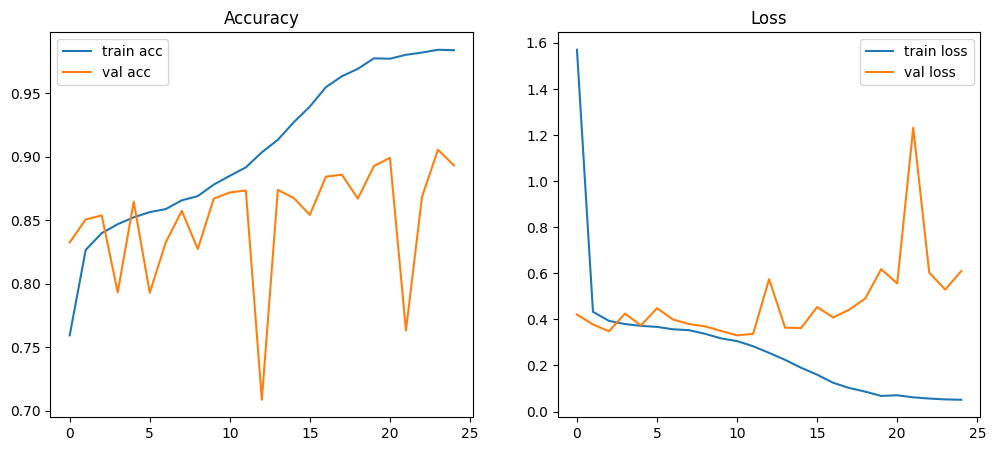

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()

plt.show()

### We can see that the val_accuracy is flacuating up on down with a slight increase since epoch 5 while the train is steadily increasing. The training accuracy is overfitting.
### While the val_loss is clearly increasing as the epochs increase which is really bad, and the traning loss is decreasing with epochs which shows that the data is starting to overfit

In [ ]:
import numpy as np

y_true = []
y_pred = []

for images, labels in test_ds:
    preds = binary_model.predict(images, verbose=0)

    y_true.extend(labels.numpy())

    y_pred.extend((preds > 0.5).astype("int32").flatten())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_true, y_pred))

Confusion Matrix:
 [[1207  182]
 [  89 1041]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.87      0.90      1389
           1       0.85      0.92      0.88      1130

    accuracy                           0.89      2519
   macro avg       0.89      0.90      0.89      2519
weighted avg       0.90      0.89      0.89      2519



## Evaluate

In [ ]:
test_loss, test_acc = binary_model.evaluate(test_ds, verbose=1)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.8927 - loss: 0.5788
Test Accuracy: 0.8904
Test Loss: 0.6238


#New Model

In [ ]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

binary_model = Sequential([
    Conv2D(32, (3,3), activation='relu', kernel_regularizer=l2(1e-4), input_shape=(224,224,3)),
    BatchNormalization(),
    MaxPooling2D(2,2), 

    Conv2D(64, (3,3), activation='relu', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu', kernel_regularizer=l2(1e-4)), 
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu', kernel_regularizer=l2(1e-4)), 
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),

    Dense(512, activation='relu', kernel_regularizer=l2(1e-4)), 
    Dropout(0.5),

    Dense(256, activation='relu', kernel_regularizer=l2(1e-4)), 
    Dropout(0.4),

    Dense(1, activation='sigmoid') 
])

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )]

binary_model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history = binary_model.fit(train_ds,epochs=30,validation_data=val_ds,callbacks=callbacks,verbose=1)

Epoch 1/30
627/627 ━━━━━━━━━━━━━━━━━━━━ 62s 83ms/step - accuracy: 0.7216 - loss: 2.6022 - val_accuracy: 0.7965 - val_loss: 0.7334
Epoch 2/30
627/627 ━━━━━━━━━━━━━━━━━━━━ 46s 73ms/step - accuracy: 0.7982 - loss: 0.7697 - val_accuracy: 0.8486 - val_loss: 0.6306
Epoch 3/30
627/627 ━━━━━━━━━━━━━━━━━━━━ 81s 71ms/step - accuracy: 0.8409 - loss: 0.6367 - val_accuracy: 0.8494 - val_loss: 0.5959
Epoch 4/30
627/627 ━━━━━━━━━━━━━━━━━━━━ 45s 72ms/step - accuracy: 0.8587 - loss: 0.5919 - val_accuracy: 0.8786 - val_loss: 0.5355
Epoch 5/30
627/627 ━━━━━━━━━━━━━━━━━━━━ 46s 73ms/step - accuracy: 0.8715 - loss: 0.5379 - val_accuracy: 0.8602 - val_loss: 0.5613
Epoch 6/30
627/627 ━━━━━━━━━━━━━━━━━━━━ 82s 73ms/step - accuracy: 0.8696 - loss: 0.5201 - val_accuracy: 0.8778 - val_loss: 0.5203
Epoch 7/30
627/627 ━━━━━━━━━━━━━━━━━━━━ 45s 72ms/step - accuracy: 0.8724 - loss: 0.5063 - val_accuracy: 0.8850 - val_loss: 0.4639
Epoch 8/30
627/627 ━━━━━━━━━━━━━━━━━━━━ 45s 72ms/step - accuracy: 0.8835 - loss: 0.4646 - 

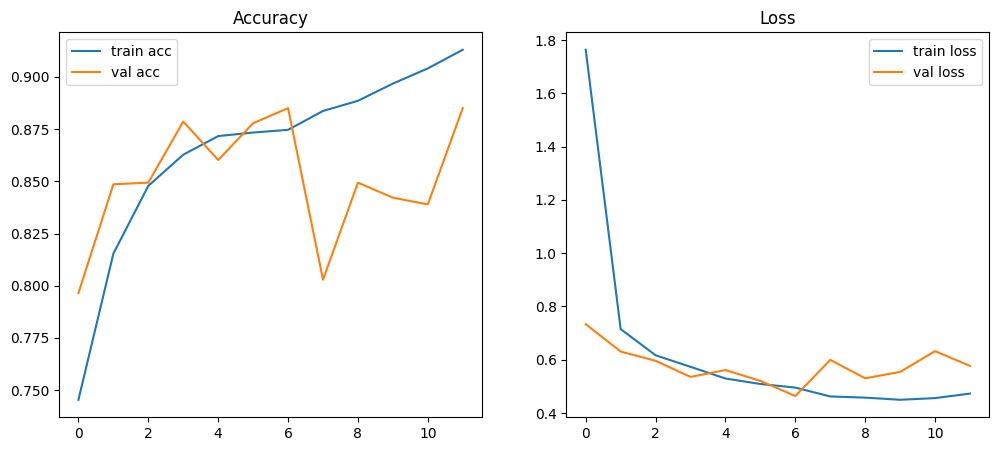

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()

plt.show()

In [ ]:
import numpy as np

y_true = []
y_pred = []

# Loop through test dataset
for images, labels in test_ds:
    preds = binary_model.predict(images, verbose=0)

    # Append true labels
    y_true.extend(labels.numpy())

    # Convert probabilities → binary predictions
    y_pred.extend((preds > 0.5).astype("int32").flatten())

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_true, y_pred))


Confusion Matrix:
 [[1234  168]
 [ 102 1015]]

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.88      0.90      1402
           1       0.86      0.91      0.88      1117

    accuracy                           0.89      2519
   macro avg       0.89      0.89      0.89      2519
weighted avg       0.89      0.89      0.89      2519



# Evaluate

In [ ]:
# Evaluate on test dataset
test_loss, test_acc = binary_model.evaluate(test_ds, verbose=1)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.8998 - loss: 0.4433
Test Accuracy: 0.8908
Test Loss: 0.4587
